# New timing result of computing the log determinant of the matrix 

### The matrix is generated from octree reordered Helmholtz Single Layer with the different refinement level. Here, we choose the refinement level as 3 and 4.

In [1]:
import bempp.api
import numpy as np
import scipy
import time
import math
import scipy.linalg 
import scipy.linalg.interpolative as sli
%matplotlib inline
from matplotlib import pyplot as plt
bempp.api.enable_console_logging()

<StreamHandler stderr (DEBUG)>

In [2]:
grid = bempp.api.shapes.regular_sphere(4)
print(f"Number of elements: {grid.number_of_elements}")

Number of elements: 2048


In [3]:
space = bempp.api.function_space(grid, "DP", 0)

In [4]:
mat = bempp.api.operators.boundary.laplace.single_layer(space, space, space).weak_form().A

root:INFO: OpenCL Device set to: pthread-Intel(R) Xeon(R) W-2155 CPU @ 3.30GHz
root:INFO: Regular kernel vector length: 8 (double precision)
root:INFO: Regular kernel runtime [ms]: 38.986396
root:INFO: Singular kernel runtime [ms]: 22.251580999999998


In [5]:
from bempp.api.utils import Octree
box = grid.bounding_box
vertices = np.empty((3,space.global_dof_count),np.float64)
for index in range(space.global_dof_count):
    elem,local_id = space.global2local[index][0]
    edge_id = grid.element_edges[local_id,elem]
    vertices[:,index] = .5*(grid.vertices[:,grid.edges[0,edge_id]] + grid.vertices[:,grid.edges[0,edge_id]])
tree = Octree(box[:,0],box[:,1], 2,vertices)

In [6]:
sorted_indices = tree.sorted_indices

Construct the original matrix

In [7]:
n = grid.number_of_elements
nboxes = 64
size = n // nboxes

In [8]:
sorted_mat = mat[:, sorted_indices][sorted_indices, :]
#sorted_mat[0:n//2,n//2:] = np.zeros((n//2,n//2))
#sorted_mat[n//2:,0:n//2] = np.zeros((n//2,n//2))

In [9]:
def get_box(nx, ny, sorted_mat, nboxes, n):
    """Return the content of a given box"""
    xrange = [nx * size, (1 + nx) * size] 
    yrange = [ny * size, (1 + ny) * size] 
    return sorted_mat[xrange[0]:xrange[1], yrange[0]:yrange[1]] 

In [10]:
def plot_box_ranks(sorted_mat, nboxes, n, tol=1E-8):
    """Plot rank of the boxes."""
    from scipy.linalg import svdvals
    ranks = np.zeros((nboxes,nboxes),dtype='int32')
    for i in range(nboxes):
        for j in range(nboxes):
            m = get_box(i, j, sorted_mat, nboxes, n)
            s = svdvals(m)
            ranks[i,j] = np.sum(s>tol)
    plt.imshow(ranks, cmap='Accent')
    plt.colorbar()

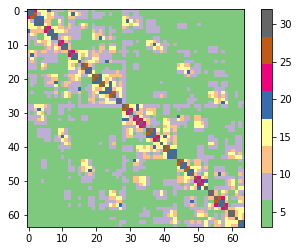

In [11]:
plot_box_ranks(sorted_mat,nboxes,n)

 Return $A_{i}$, which is the combination of the $i$th off-diagonal block row and the transpose of the $i$th off-diagonal block column.

In [12]:
def get_con_box(i,sorted_mat,nboxes,n):
    BB = sorted_mat[i * size : (i + 1) * size, :]
    B = np.delete(BB, np.s_[i*size : (i+1)*size], axis = 1)
    
    CC = np.transpose(sorted_mat[:, i * size : (i + 1) * size])
    C = np.delete(CC, np.s_[i*size : (i+1)*size], axis = 1)
    return np.hstack((B,C))

 Return $L_{i}$ and $R_{j}$ inside of $A_{ij} = L_{i}S_{ij}R_{j}$, where $R_{j} = L_{j}^{T}$ and $L_{i}$ is computed from the two-sided interpolated decompositon of $A_{i}$, which writes $A_{i} = L_{i}S_{i}V_{i}$. Also return the matrix S constructed by using the original matrix and the index set which is generated when computing $L_{i}$.


In [13]:
def L(i,k,sorted_mat,nboxes,n):
    idx1,proj1 = sli.interp_decomp(get_con_box(i,sorted_mat,nboxes,n), k, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box(i,sorted_mat,nboxes,n),k,idx1)
    B1_trans = np.transpose(B1)
    
    idx2,proj2 = sli.interp_decomp(B1_trans, k, rand = False)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    P2 = np.transpose(P2_trans)
    return P2,idx2

In [14]:
def index_set(k,sorted_mat,nboxes,n):
    l = []
    for i in range(nboxes):
        l.append(L(i,k,sorted_mat,nboxes,n)[1][0:k])
    return l

In [15]:
def S(k,sorted_mat,nboxes,n):
    ll = index_set(k,sorted_mat,nboxes,n)
    mat = np.zeros((k*nboxes,k*nboxes))
    for i in range(nboxes):
        for j in range(nboxes):
            if i != j:
                mat_ =  get_box(i,j,sorted_mat,nboxes,n)[ll[i],:]
                mat[i*k:(i+1)*k,j*k:(j+1)*k] = mat_[:,ll[j]]
    return mat

In [17]:
gridindex_set(3,sorted_mat,nboxes,n)

TypeError: 'Grid' object is not subscriptable

In [16]:
def R(i,k,sorted_mat,nboxes,n):
    RR = np.transpose(L(i,k,sorted_mat,nboxes,n)[0])
    return RR

#### Construct the structured matrix and its LU decomposition
$\tilde{A} = 
\begin{bmatrix}
    D & L & 0 \\
    R & 0 & -I \\
    0 & -I & S
\end{bmatrix}
= \begin{bmatrix}
    I & 0 & 0 \\
    RD^{-1} & I & 0 \\
    0 & (RD^{-1}L)^{-1} & I
\end{bmatrix}  \begin{bmatrix}
    D & L & 0 \\
    0 & -RD^{-1}L & -I \\
    0 & 0 & S+(RD^{-1}L)^{-1}
\end{bmatrix}$

Then, we do the LU decomposition on each diagonal block's diagonal block (i.e. $A_{ii}$ and $-R_{i}A_{ii}^{-1}L_{i}$) and $S+(RD^{-1}L)^{-1}$.

#### Construct the matrix $S+(RD^{-1}L)^{-1}$ first

In [17]:
def new_S(k,A,nboxes,n):
    mat_ = S(k,sorted_mat,nboxes,n)
    for i in range(nboxes):
        mat_[i*k:(i+1)*k,i*k:(i+1)*k] = np.linalg.inv(R(i,k,sorted_mat,nboxes,n) @ np.linalg.inv(get_box(i,i,sorted_mat,nboxes,n)) @ L(i,k,sorted_mat,nboxes,n)[0])
    return mat_

#### Compute the log determinant of the structured matrix $\tilde{A}$

In [18]:
def logdet_method2(k,sorted_mat,nboxes,n):
    a1 = 0
    p1,l1,u1 = scipy.linalg.lu(new_S(k,sorted_mat,nboxes,n))
    for i in range(k*nboxes):
        a1 += math.log(abs(u1[i,i]))
        
    a2 = 0
    for i in range (nboxes):
        p2,l2,u2 = scipy.linalg.lu(get_box(i,i,sorted_mat,nboxes,n))
        for j in range(size):
            a2 +=math.log(abs(u2[j,j]))
            
    a3 = 0
    for i in range(nboxes):
        p3,l3,u3 = scipy.linalg.lu(-R(i,k,sorted_mat,nboxes,n)@np.linalg.inv(get_box(i,i,sorted_mat,nboxes,n)) @L(i,k,sorted_mat,nboxes,n)[0] )
        for j in range(k):
            a3 += math.log(abs(u3[j,j]))
    return a1 + a2 + a3

Compute the time under different rank

In [105]:
def time_logdet(k,sorted_mat,nboxes,n):
    start_time = time.time()
    a = logdet_method2(k,sorted_mat,nboxes,n)
    end_time = time.time()
    b = end_time - start_time
    return b

#### Level 4 time

In [106]:
l_time = []
for i in range(1,size+1):
    l_time.append(time_logdet(i,sorted_mat,nboxes,n))

#### Level 3 time

In [76]:
l_time3 = []
for i in range(1,size+1):
    l_time3.append(time_logdet(i,sorted_mat,nboxes,n))

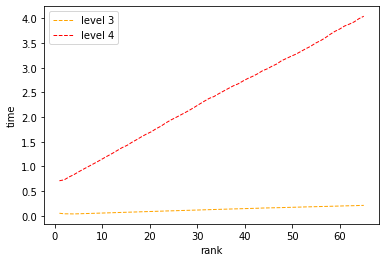

In [107]:
k_time = np.linspace(1,size+1,size)


plt.plot(k_time,l_time3,color='orange',linewidth=1.0,linestyle='--')
plt.plot(k_time,l_time,color='red',linewidth=1.0,linestyle='--')

plt.legend(['level 3','level 4'])

plt.ylabel('time')
plt.xlabel('rank')
plt.show()

#### ***************Note that when I set the refinement level as 5, then the size of the matrix becomes $8192*8192$, then the computing time is at most 130 seconds.

Compute the log determinant of the original matrix

#### Level 3 exact value

In [20]:
P3,L3,U3 = scipy.linalg.lu(sorted_mat)

logdet3 = 0
for i in range(n):
    logdet3 += math.log(U3[i,i])
l3_det_exact = []
for i in range(size):
    l3_det_exact.append(logdet3)

#### Level 3 exact value of $A_{\infty}$

In [24]:
PP3,LL3,UU3 = scipy.linalg.lu(sorted_mat)

logdet33 = 0
for i in range(n):
    logdet33 += math.log(UU3[i,i])

#### Level 3 approximated value

In [21]:
l3_det = []
for i in range(1,size+1):
    l3_det.append(logdet_method2(i,sorted_mat,nboxes,n))

#### Level 3 approximated value of $A_{\infty}$

In [25]:
l33_det = []
for i in range(1,size+1):
    l33_det.append(logdet_method2(i,sorted_mat,nboxes,n))

#### $\log\det(A) - \log\det(A_{\infty})$ in level 3

In [26]:
diff_logdet3 = []
for i in range(size):
    diff_logdet3.append(l3_det[i]-l33_det[i])

In [28]:
"""Exact difference"""
diff3 = logdet3 - logdet33
diff_exact3 = []
for i in range(size):
    diff_exact3.append(diff3)

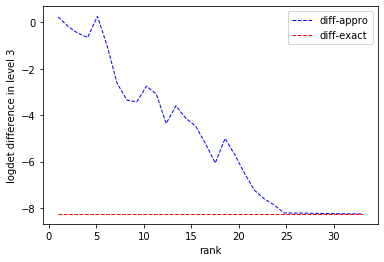

In [31]:
k_det = np.linspace(1,size+1,size)
plt.plot(k_det,diff_logdet3,color='blue',linewidth=1.0,linestyle='--')
plt.plot(k_det,diff_exact3,color='red',linewidth=1.0,linestyle='--')
plt.legend(['diff-appro','diff-exact'])
plt.ylabel('logdet difference in level 3')
plt.xlabel('rank')
plt.show()

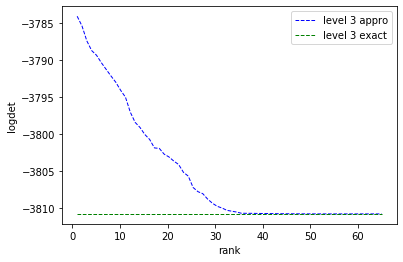

In [81]:
k_det = np.linspace(1,size+1,size)

plt.plot(k_det,l3_det,color='blue',linewidth=1.0,linestyle='--')
plt.plot(k_det,l3_det_exact,color='green',linewidth=1.0,linestyle='--')

plt.legend(['level 3 appro','level 3 exact'])

plt.ylabel('logdet')
plt.xlabel('rank')
plt.show()

#### Level 4 exact value

In [19]:
P4,L4,U4 = scipy.linalg.lu(sorted_mat)

logdet4 = 0
for i in range(n):
    logdet4 += math.log(U4[i,i])
    
l4_det_exact = []
for i in range(size):
    l4_det_exact.append(logdet4)

#### Level 4 exact value of $A_{\infty}$

In [23]:
PP4,LL4,UU4 = scipy.linalg.lu(sorted_mat)

logdet44 = 0
for i in range(n):
    logdet44 += math.log(UU4[i,i])

#### Level 4 approximated value

In [20]:
l4_det = []
for i in range(1,size+1):
    l4_det.append(logdet_method2(i,sorted_mat,nboxes,n))

#### Level 4 approximated value of $A_{\infty}$

In [24]:
l44_det = []
for i in range(1,size+1):
    l44_det.append(logdet_method2(i,sorted_mat,nboxes,n))

$\log\det(A) - \log(A_{\infty})$ in level 4

In [25]:
diff_logdet4 = []
for i in range(size):
    diff_logdet4.append(l4_det[i]-l44_det[i])

In [26]:
"""Exact difference"""
diff4 = logdet4 - logdet44
diff_exact4 = []
for i in range(size):
    diff_exact4.append(diff4)

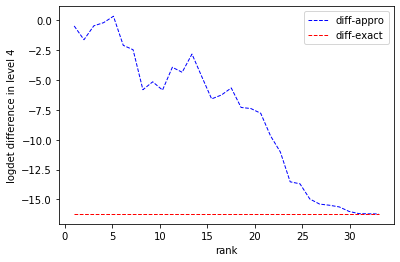

In [27]:
k_det = np.linspace(1,size+1,size)
plt.plot(k_det,diff_logdet4,color='blue',linewidth=1.0,linestyle='--')
plt.plot(k_det,diff_exact4,color='red',linewidth=1.0,linestyle='--')
plt.legend(['diff-appro','diff-exact'])
plt.ylabel('logdet difference in level 4')
plt.xlabel('rank')
plt.show()

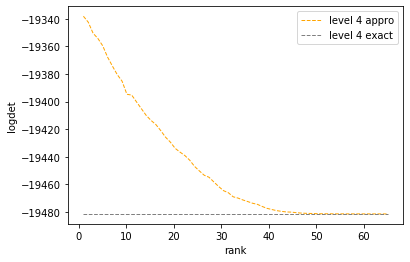

In [110]:
k_det = np.linspace(1,size+1,size)

plt.plot(k_det,l4_det,color='orange',linewidth=1.0,linestyle='--')
plt.plot(k_det,l4_det_exact,color='grey',linewidth=1.0,linestyle='--')

plt.legend(['level 4 appro','level 4 exact'])

plt.ylabel('logdet')
plt.xlabel('rank')
plt.show()

#### Level 3 relative error

In [82]:
relative_error3 = []
for i in range(size):
    a = abs((l3_det[i] - logdet3)/logdet3)
    relative_error3.append(np.log10(a))

#### Level 4 relative error

In [111]:
relative_error4 = []
for i in range(size):
    a = abs((l4_det[i] - logdet4)/logdet4)
    relative_error4.append(np.log10(a))

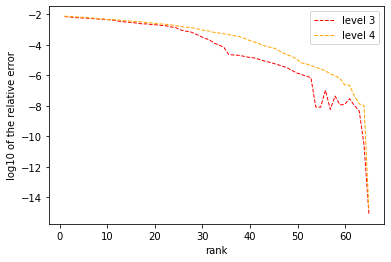

In [112]:
k_det = np.linspace(1,size+1,size)

plt.plot(k_det,relative_error3,color='red',linewidth=1.0,linestyle='--')
plt.plot(k_det,relative_error4,color='orange',linewidth=1.0,linestyle='--')


plt.legend(['level 3','level 4'])

plt.ylabel('log10 of the relative error')
plt.xlabel('rank')
plt.show()